In [2]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


[Learn the Basics](intro.html) ||
**Quickstart** ||
[Tensors](tensorqs_tutorial.html) ||
[Datasets & DataLoaders](data_tutorial.html) ||
[Transforms](transforms_tutorial.html) ||
[Build Model](buildmodel_tutorial.html) ||
[Autograd](autogradqs_tutorial.html) ||
[Optimization](optimization_tutorial.html) ||
[Save & Load Model](saveloadrun_tutorial.html)

# Quickstart
This section runs through the API for common tasks in machine learning. Refer to the links in each section to dive deeper.

## Working with data
PyTorch has two [primitives to work with data](https://pytorch.org/docs/stable/data.html):
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.


In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

PyTorch offers domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html),
all of which include datasets. For this tutorial, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
CIFAR, COCO ([full list here](https://pytorch.org/vision/stable/datasets.html)). In this tutorial, we
use the FashionMNIST dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
``target_transform`` to modify the samples and labels respectively.



In [4]:
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Set up transformer
# note The values 0.1307 and 0.3081 are the global mean and standard deviation of the MNIST dataset
mnist_global_mean = 0.1307
mnist_global_stdev = 0.3081
transformer = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mnist_global_mean,), (mnist_global_stdev,))])

# Download training data from open datasets.
training_data = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transformer,
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transformer,
)

We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.



In [5]:
print(training_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [6]:
batch_size_train = 64
batch_size_test = 1000

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size_train, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([1000, 1, 28, 28])
Shape of y: torch.Size([1000]) torch.int64


Read more about [loading data in PyTorch](data_tutorial.html).




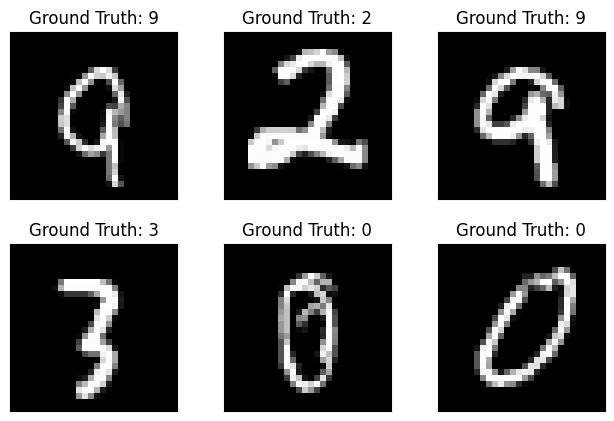

In [7]:
# import matplotlib.pyplot as plt

examples = enumerate(train_dataloader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

--------------




## Creating Models
To define a neural network in PyTorch, we create a class that inherits
from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
operations in the neural network, we move it to the GPU or MPS if available.



In [8]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define a convolution neural model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        # Feature Extraction Stage
        self.feature_maps_stack = nn.Sequential(
            # A convolution layer with 10 5x5 filters
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
            # A max pooling layer with a 2x2 window and a ReLU function applied
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            # A convolution layer with 20 5x5 filters
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5),
            # A dropout layer with a 0.5 dropout rate (50%)
            nn.Dropout2d(p=0.5),
            # A max pooling layer with a 2x2 window and a ReLU function applied
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        
        # Classification Stage
        self.classify_stack = nn.Sequential(
            # A flattening operation 
            nn.Flatten(),
            # followed by a fully connected Linear layer with 50 nodes 
            nn.Linear(320, 50),
            # and a ReLU function on the output
            nn.ReLU(),
            # A final fully connected Linear layer with 10 nodes
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        features = self.feature_maps_stack(x)
        logits = self.classify_stack(features)
        
        # and the log_softmax function applied to the output
        return nn.functional.log_softmax(logits, dim=1)

model = NeuralNetwork().to(device)
print(model)

Using mps device
NeuralNetwork(
  (feature_maps_stack): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): Dropout2d(p=0.5, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
  )
  (classify_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=320, out_features=50, bias=True)
    (2): ReLU()
    (3): Linear(in_features=50, out_features=10, bias=True)
  )
)


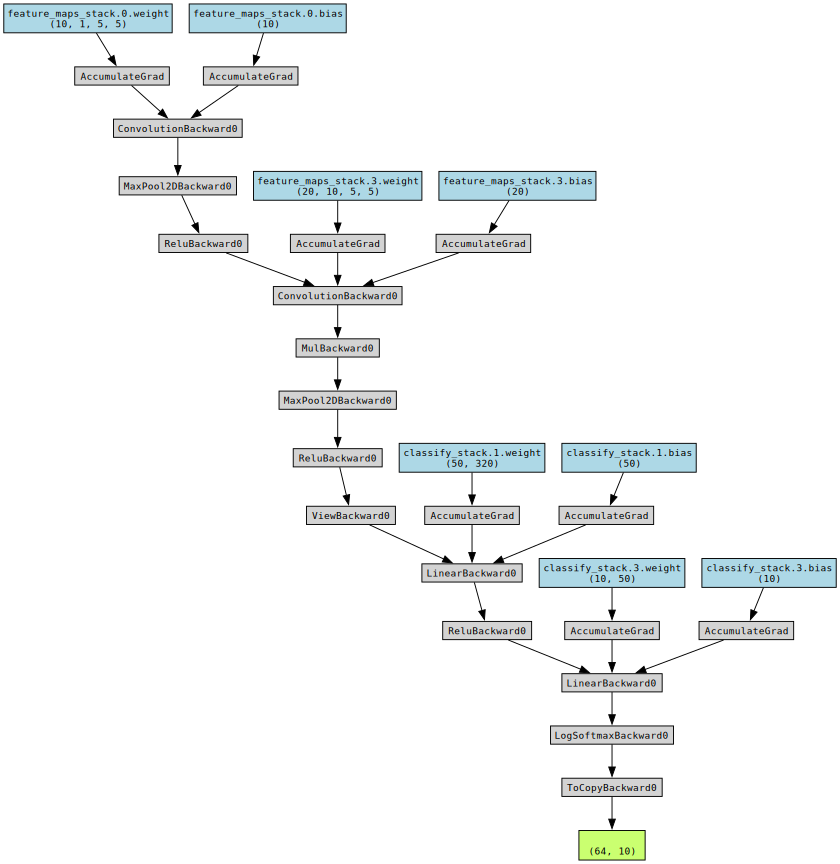

In [31]:
# plot out networks
from torchviz import make_dot

examples = enumerate(train_dataloader)
batch_idx, (example_data, example_targets) = next(examples)

sample_pred = model(example_data.to(device)).cpu()
make_dot(sample_pred, params=dict(model.named_parameters()))

Read more about [building neural networks in PyTorch](buildmodel_tutorial.html).




--------------




## Optimizing the Model Parameters
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)
and an [optimizer](https://pytorch.org/docs/stable/optim.html).



In [ ]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.01
momentum = 0.5
log_interval = 100
n_epochs = 3

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_dataloader.dataset) for i in range(n_epochs + 1)]

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.



In [ ]:
def train(epoch):
    model.train()
    for batch, (data, target) in enumerate(train_dataloader):
        # send the data to hardware device
        data, target = data.to(device), target.to(device)
        # reset zero gradients and forward pass in model
        optimizer.zero_grad()
        output = model(data)
        # compute loss function
        loss = nn.functional.nll_loss(output, target)
        # backward pass to computer gradients
        loss.backward()
        # update model with optimizer
        optimizer.step()

        if batch % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch * len(data), len(train_dataloader.dataset),
                100. * batch / len(train_dataloader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch*64) + ((epoch-1)*len(train_dataloader.dataset)))
            
            torch.save(model.state_dict(), 'model.pth')
            torch.save(optimizer.state_dict(), 'optimizer.pth')

We also check the model's performance against the test dataset to ensure it is learning.



In [249]:
def test():
    # enable the testing mode
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_dataloader:
            # send the data to hardware device
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Compute the negative log likelihood loss
            test_loss += nn.functional.nll_loss(output, target, size_average=False).item()
            # Get the index of the maximum log-probability
            pred = output.data.max(1, keepdim=True)[1]
            # Count the number of correct predictions
            correct += pred.eq(target.data.view_as(pred)).sum()
    
    # Compute average loss        
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



In [ ]:
epochs = 5
test()
for t in range(1, n_epochs + 1):
    print(f"Epoch {t+1}\n-------------------------------")
    train(t)
    test()
print("Done!")

Read more about [Training your model](optimization_tutorial.html).




--------------




## Saving Models
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).



In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

## Loading Models

The process for loading a model includes re-creating the model structure and loading
the state dictionary into it.



In [248]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [ ]:
import copy

with torch.no_grad():
  example_data_gpu = example_data.to(device)
  output = model(example_data_gpu)
  example_data_local = [tensor.cpu() for tensor in example_data_gpu]

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data_local[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

This model can now be used to make predictions.



In [ ]:
continued_network = NeuralNetwork()
continued_optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
                                momentum=momentum)

In [ ]:
network_state_dict = torch.load("model.pth")
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load("optimizer.pth")
continued_optimizer.load_state_dict(optimizer_state_dict)

In [ ]:
for i in range(4,9):
  test_counter.append(i*len(train_dataloader.dataset))
  train(i)
  test()

Read more about [Saving & Loading your model](saveloadrun_tutorial.html).




In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig